In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("whats the date today?")

[{'url': 'https://www.timeanddate.com/',
  'content': 'Find the current time and date in different locations and time zones around the world. Explore tools for calculating time differences, creating calendars, and planning events across time zones.'},
 {'url': 'https://www.calendardate.com/todays.htm',
  'content': "Find out the date, time zone, day number, week number, month number, leap year, daylight saving time, and more for today's date. See today's date in different formats and learn about upcoming holidays and zodiac signs."}]

In [29]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

#With Annotated  - messages is expected to be a list, and the add_messages function or callable provides additional context or metadata about this list
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


#adds message to existing state
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [30]:
import json

from langchain_core.messages import ToolMessage

#Next we need to create a function to actually run the tools if they are called. 
# We'll do this by adding the tools to a new node.

#Below, implement a BasicToolNode that checks the most recent message in the state and calls 
# tools if the message contains tool_calls (llm must have function calling capabilities)
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool]) #You can instead use prebuilt from langgraph.prebuilt import ToolNode
graph_builder.add_node("tools", tool_node)

In [31]:
from typing import Literal

# Defining the conditional edge: Self built function that routes to the ToolNode if the last message has tool calls. Otherwise, it routes to the end.

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

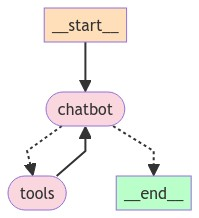

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [33]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: [{"url": "https://www.britannica.com/biography/Donald-Trump", "content": "Trump was the third president in U.S. history (after Andrew Johnson in 1868 and Bill Clinton in 1998) to be impeached by the U.S. House of Representatives and the only president to be impeached twice\u2014once (in 2019) for abuse of power and obstruction of Congress in connection with the Ukraine scandal and once (in 2021) for \u201cincitement of insurrection\u201d in connection with the storming of the United States Capitol by a violent mob of Trump supporters as Congress met in joint session to ceremonially count electoral college votes from the 2020 presidential election. Trump was able to reduce his tax obligations to levels significantly below the average for the wealthiest Americans by claiming massive losses on many of his businesses; by deducting as business expenses costs associated with his residences and his personal aircraft; and by 

In [36]:
from typing import Annotated, Union

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# State Definition: State is a dictionary that holds the chatbot messages, annotated for graph message handling.
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()